<a href="https://colab.research.google.com/github/UrayLaszlo/Airbnb_project/blob/main/nyc_airbnb_02_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import re, requests, pandas as pd, io, gzip, pathlib, os, datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re



In [2]:
# Install libraries
%%bash
pip install -q geopandas shap prophet xgboost lightgbm shapely contextily pyarrow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 85.9 MB/s eta 0:00:00


In [3]:
listings = pd.read_csv('listings.csv.gz')
#calendar = pd.read_csv('calendar.csv.gz')
#reviews = pd.read_csv('reviews.csv.gz')

listings#, calendar, reviews

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,36121,https://www.airbnb.com/rooms/36121,20250301213336,2025-03-03,city scrape,Lg Rm in Historic Prospect Heights,Cozy space share in the heart of a great neigh...,Full of tree-lined streets and beautiful brown...,https://a0.muscache.com/pictures/8776354/35b32...,62165,...,5.00,5.00,5.00,NaN,f,1,0,1,0,0.05
1,36647,https://www.airbnb.com/rooms/36647,20250301213336,2025-03-03,city scrape,"1 Bedroom & your own Bathroom, Elevator Apartment",Private bedroom with your own bathroom in a 2 ...,"Manhattan, SE corner of 2nd Ave/ E. 110th street",https://a0.muscache.com/pictures/miso/Hosting-...,157798,...,4.90,4.38,4.71,NaN,f,1,0,1,0,0.58
2,38663,https://www.airbnb.com/rooms/38663,20250301213336,2025-03-02,city scrape,Luxury Brownstone in Boerum Hill,"Beautiful, large home in great hipster neighbo...","diverse, lively, hip, cool: loaded with restau...",https://a0.muscache.com/pictures/miso/Hosting-...,165789,...,4.88,4.86,4.62,OSE-STRREG-0001784,f,1,0,1,0,0.28
3,38833,https://www.airbnb.com/rooms/38833,20250301213336,2025-03-03,city scrape,Spectacular West Harlem Garden Apt,This is a very large and unique space. An inc...,West Harlem is now packed with great restauran...,https://a0.muscache.com/pictures/7554f9e5-4ab0...,166532,...,4.96,4.79,4.82,OSE-STRREG-0000476,f,1,1,0,0,1.36
4,39282,https://www.airbnb.com/rooms/39282,20250301213336,2025-03-02,city scrape,“Work-from-home” from OUR home.,*Monthly Discount will automatically apply <br...,THE NEIGHBORHOOD:<br />Our apartment is locate...,https://a0.muscache.com/pictures/ef8f43ad-d967...,168525,...,4.88,4.85,4.78,OSE-STRREG-0001150,f,2,0,2,0,1.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37429,1366333532374850165,https://www.airbnb.com/rooms/1366333532374850165,20250301213336,2025-03-02,city scrape,Beautiful 1-Bed Apt in Harlem!,Welcome to your temporary home in the vibrant ...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,40019013,...,NaN,NaN,NaN,NaN,f,1,0,1,0,NaN
37430,1366717321390111215,https://www.airbnb.com/rooms/1366717321390111215,20250301213336,2025-03-02,city scrape,Private Room w/ Ensuite Bath H,Stylish Private Rooms w/ En-Suite Baths in Bro...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,483056418,...,NaN,NaN,NaN,NaN,f,24,0,24,0,NaN
37431,1366721904709517353,https://www.airbnb.com/rooms/1366721904709517353,20250301213336,2025-03-02,city scrape,2 Bedroom on East Side,Located in the Murray Hill area and occupies a...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,30283594,...,NaN,NaN,NaN,NaN,f,48,48,0,0,NaN
37432,1366722692755341871,https://www.airbnb.com/rooms/1366722692755341871,20250301213336,2025-03-02,city scrape,Stylish 2Bd near Bryant Park,Enjoy everything the city has to offer while l...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,407304997,...,NaN,NaN,NaN,NaN,t,25,25,0,0,NaN


In [4]:
def classify_column(dtype, n_unique, pct_missing, n_rows):
    """Heuristic label for each column."""
    # IDs / constant-ish ----------------------------------------------------
    if n_unique == n_rows:                       # every row different
        return "id-like"
    if n_unique <= 1:                            # all the same
        return "constant"

    # Core data types -------------------------------------------------------
    if pd.api.types.is_bool_dtype(dtype):
        return "boolean"
    if pd.api.types.is_datetime64_any_dtype(dtype):
        return "datetime"
    if pd.api.types.is_numeric_dtype(dtype):
        # hand-wavy split between discrete and continuous
        return "numeric_discrete" if n_unique < 0.02 * n_rows else "numeric_continuous"
    # object, string, category, etc.
    return "categorical_low"  if n_unique < 20 else "categorical_high"

def column_summary(listings):
    """Return a DataFrame describing every column."""
    n_rows = len(listings)
    out = (
        pd.DataFrame({
            "dtype":       listings.dtypes,
            "n_unique":    listings.nunique(dropna=False),
            "pct_missing": listings.isna().mean().round(3) * 100,
        })
        .assign(
            category=lambda t: [
                classify_column(t.dtype[i], t.n_unique[i], t.pct_missing[i], n_rows)
                for i in range(len(t))
            ]
        )
        .sort_values("category")
    )
    return out

# --- run it on your data ---
summary = column_summary(listings)
#summary.head(20)        # peek, or just display(summary) in Colab


<ipython-input-4-946f708c94ee>:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  classify_column(t.dtype[i], t.n_unique[i], t.pct_missing[i], n_rows)


In [5]:
summary

,dtype,n_unique,pct_missing,category
amenities,object,30306,0.0,categorical_high
property_type,object,70,0.0,categorical_high
neighbourhood_cleansed,object,223,0.0,categorical_high
first_review,object,4338,31.5,categorical_high
last_review,object,3249,31.5,categorical_high
...,...,...,...,...
availability_365,int64,366,0.0,numeric_discrete
number_of_reviews,int64,498,0.0,numeric_discrete
number_of_reviews_ltm,int64,173,0.0,numeric_discrete
minimum_nights_avg_ntm,float64,457,0.0,numeric_discrete


In [6]:
import os, sys, textwrap, math, json, itertools, collections, re

rows = []
for col in listings.columns:
    unique_vals = listings[col].dropna().unique()[:5]  # first 5 unique non‑null values
    rows.append({
        "column": col,
        "dtype": str(listings[col].dtype),
        "sample_values": ", ".join([str(v) for v in unique_vals])
    })

sample_df = pd.DataFrame(rows)


In [7]:
sample_df

,column,dtype,sample_values
0,id,int64,"36121, 36647, 38663, 38833, 39282"
1,listing_url,object,"https://www.airbnb.com/rooms/36121, https://ww..."
2,scrape_id,int64,20250301213336
3,last_scraped,object,"2025-03-03, 2025-03-02"
4,source,object,"city scrape, previous scrape"
...,...,...,...
74,calculated_host_listings_count,int64,"1, 2, 3, 4, 6"
75,calculated_host_listings_count_entire_homes,int64,"0, 1, 3, 2, 8"
76,calculated_host_listings_count_private_rooms,int64,"1, 0, 2, 3, 6"
77,calculated_host_listings_count_shared_rooms,int64,"0, 1, 2, 4, 3"


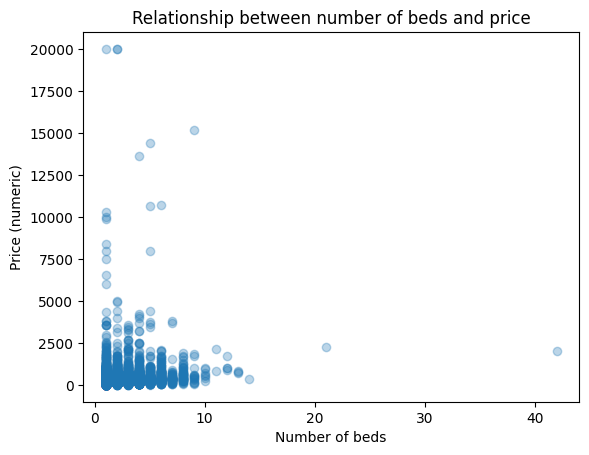

Pearson correlation (beds vs. price): 0.201


(None,
        beds  price_num
 0       1.0      200.0
 1       1.0       82.0
 2       5.0      765.0
 3       1.0      139.0
 4       1.0      130.0
 ...     ...        ...
 37427   1.0      221.0
 37428   1.0       87.0
 37429   1.0       72.0
 37431   3.0      299.0
 37432   2.0      200.0
 
 [21594 rows x 2 columns],
     beds  median_price
 0    1.0         109.0
 1    2.0         170.0
 2    3.0         210.0
 3    4.0         259.0
 4    5.0         275.0
 5    6.0         366.5
 6    7.0         362.0
 7    8.0         544.0
 8    9.0         470.0
 9   10.0         576.0
 10  11.0        1467.0
 11  12.0        1019.5
 12  13.0         750.0
 13  14.0         359.0
 14  21.0        2272.0
 15  42.0        2029.0)

In [8]:
def to_price(val):
    if pd.isna(val):
        return np.nan
    if isinstance(val, str):
        # strip currency symbols and thousands separators
        val = re.sub(r'[^\d.]', '', val)
    try:
        return float(val)
    except ValueError:
        return np.nan

df_clean = listings.copy()
df_clean['price_num'] = df_clean['price'].apply(to_price)

df_plot = (
    df_clean[['beds', 'price_num']]
    .dropna()
    .loc[lambda d: (d['beds'] > 0) & (d['price_num'] > 0)]
)

plt.figure()
plt.scatter(df_plot['beds'], df_plot['price_num'], alpha=0.3)
plt.xlabel("Number of beds")
plt.ylabel("Price (numeric)")
plt.title("Relationship between number of beds and price")
plt.show()

median_df = (
    df_plot.groupby('beds')['price_num']
    .median()
    .reset_index()
    .rename(columns={'price_num': 'median_price'})
    .sort_values('beds')
)

pearson = df_plot['beds'].corr(df_plot['price_num'])
print(f"Pearson correlation (beds vs. price): {pearson:.3f}"), df_plot, median_df


Pearson r (beds vs. log_price): 0.379


<ipython-input-9-3af57b142157>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean['log_price'] = np.log1p(clean['price_num'])


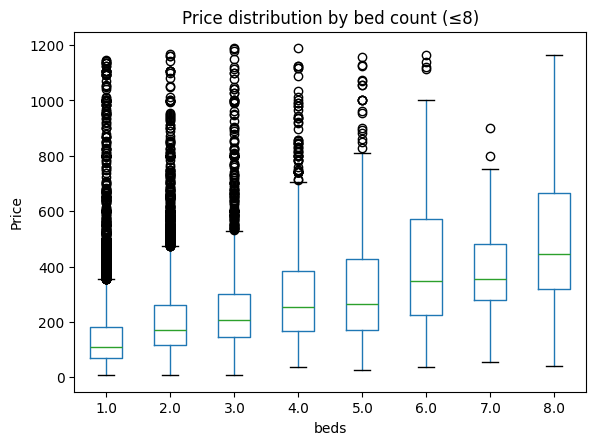

In [9]:
# 1. Drop crazy outliers (top 1 %)
hi_cap = df_plot['price_num'].quantile(0.99)
clean = df_plot[df_plot['price_num'] <= hi_cap]

# 2. Log-price correlation
clean['log_price'] = np.log1p(clean['price_num'])
print("Pearson r (beds vs. log_price):",
      round(clean['beds'].corr(clean['log_price']), 3))

# 3. Box-plots by bed count up to 8
ax = clean[clean['beds'] <= 8].boxplot(column='price_num', by='beds', grid=False)
ax.set_ylabel("Price"); ax.set_title("Price distribution by bed count (≤8)")
plt.suptitle("")
plt.show()


<Figure size 640x480 with 0 Axes>

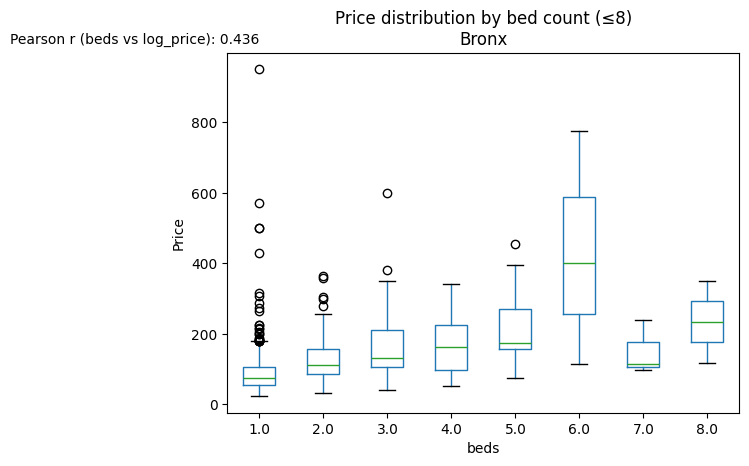

<Figure size 640x480 with 0 Axes>

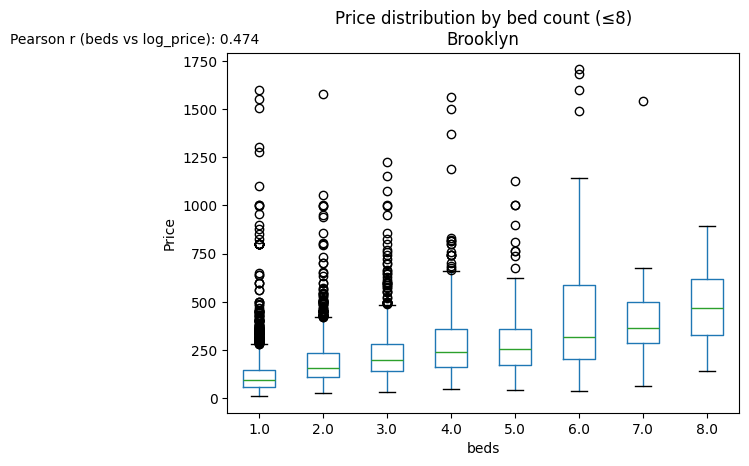

<Figure size 640x480 with 0 Axes>

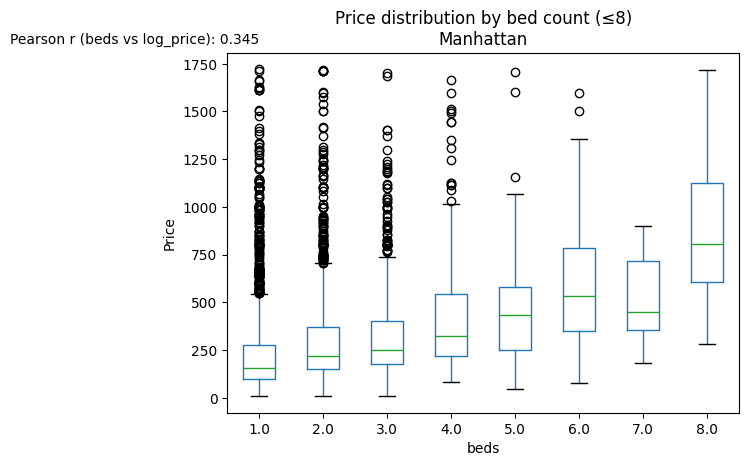

<Figure size 640x480 with 0 Axes>

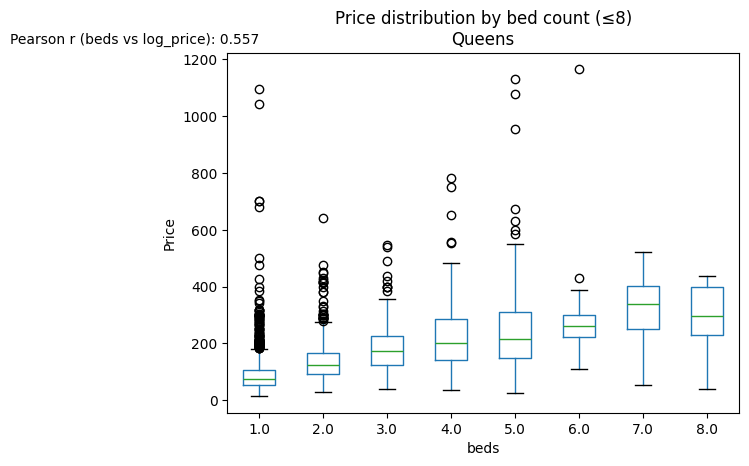

<Figure size 640x480 with 0 Axes>

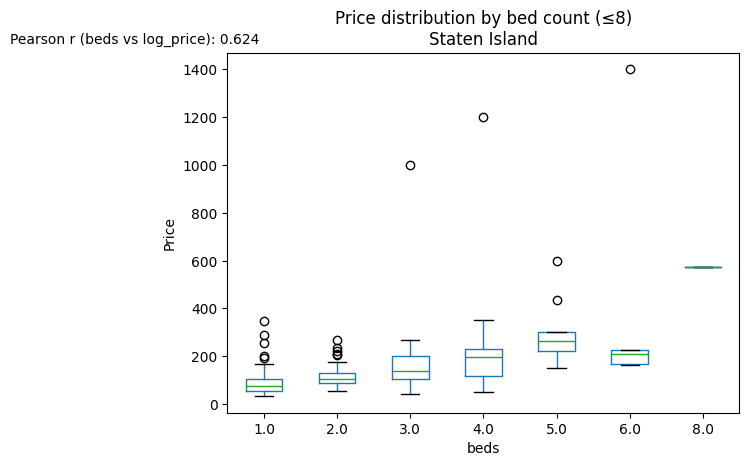

neighbourhood_group_cleansed,Bronx,Brooklyn,Manhattan,Queens,Staten Island
beds,,,,,
1.0,76.0,93.0,157.0,75.0,77.0
2.0,110.5,158.0,218.0,125.0,103.5
3.0,131.0,197.0,250.0,174.5,140.0
4.0,162.0,240.0,325.0,200.0,197.0
5.0,175.0,258.0,435.0,216.0,266.0
6.0,400.0,319.5,531.0,262.0,210.0
7.0,114.0,362.0,448.0,340.0,NaN
8.0,234.0,470.0,805.0,298.0,575.0


In [10]:
def to_price(val):
    if pd.isna(val):
        return np.nan
    if isinstance(val, str):
        val = re.sub(r'[^\d.]', '', val)  # strip $ and commas
    try:
        return float(val)
    except ValueError:
        return np.nan

dfc = listings.copy()
dfc['price_num'] = dfc['price'].apply(to_price)

# ------------------------------------------------------------------
# 3. Prep data
# ------------------------------------------------------------------
dfc = (
    dfc[['beds', 'price_num', 'neighbourhood_group_cleansed']]
    .dropna()
    .loc[lambda d: (d['beds'] > 0) & (d['price_num'] > 0)]
)

# Optional trim of extreme luxury prices (global 99.5 %)
price_cap = dfc['price_num'].quantile(0.995)
dfc = dfc[dfc['price_num'] <= price_cap]

# Focus on reasonable bed counts (≤8)
dfc = dfc[dfc['beds'] <= 8]

# ------------------------------------------------------------------
# 4. Box‑plots per neighbourhood group
# ------------------------------------------------------------------
groups = dfc['neighbourhood_group_cleansed'].dropna().unique()

for g in sorted(groups):
    grp = dfc[dfc['neighbourhood_group_cleansed'] == g]
    if grp.empty:
        continue
    plt.figure()
    grp.boxplot(column='price_num', by='beds', grid=False)
    plt.title(f"Price distribution by bed count (≤8)\n{g}")
    plt.suptitle("")
    plt.xlabel("beds")
    plt.ylabel("Price")
    # Pearson correlation on log‑price
    grp = grp.copy()
    grp['log_price'] = np.log1p(grp['price_num'])
    r = grp['beds'].corr(grp['log_price'])
    plt.figtext(0.15, 0.92, f"Pearson r (beds vs log_price): {r:.3f}", ha='right')
    plt.show()

# ------------------------------------------------------------------
# 5. Median price table
# ------------------------------------------------------------------
median_tbl = (
    dfc.groupby(['neighbourhood_group_cleansed', 'beds'])['price_num']
       .median()
       .unstack(level=0)          # columns = neighbourhood groups
       .sort_index()
)

median_tbl